# Parâmetros em regime transitório

É muito comum caracterizarmos os sistemas de controle de acordo com os seus parâmetros em regime transitório. Basicamente, inserimos uma entrada degrau ao sistema e tentamos madir alguns valores na saída que o sistema retornar, sendo elas:

- Tempo de subida (Tr): Tempo que a saída demora para sair de 10% e chegar em 90% do valor em regime estacionário.

- Tempo de atraso (Td): Tempo que a saída demora para atingir 50% do valor em regime estacionário.

- Tempo de pico (Tp): Tempo que a saída demora para atingir o valor de pico.

- Tempo de acomodação (Ts): Tempo que a saída demora pra "estabilizar" em seu valor estacionário. Essa estabilização depende do quanto de tolerância queremos permitir, sendo 5% e 2% do valor estacionário os valores mais comuns de tolerância.

- Máximo sobressinal (MSS): Dado em porcentagem, o Maximo Sobressinal é o quanto a saída ultrapassa seu valor estacionário no pico. Pode ser calculado por:

$$MSS\% = \left[ \frac{(\text{Valor de pico} - \text{Valor em regime})}{\text{Valor em regime}} \right]×100\%$$

Esses parâmetros são considerados em sistemas de ordem 2. Para os de ordem 1, somente são considerados o tempo de subida, o tempo de acomodação e a constante de tempo:

Constante de tempo ($τ$): Tempo que a saída demora para atingir 63% do valor de regime.

Veremos como calcular esses parâmetros na prática. Considere um sistema realimentado com a seguinte função de transferência de malha fechada:
$$FTMA = \frac{100}{(s^2 + 6s + 25)}$$

Como é um sistema de segunda ordem, temos que calular aqueles 5 parâmetros no python:

In [ ]:
!pip install control matplotlib numpy

Vamos primeiro importar algumas bibliotecas importantes:

In [18]:
import control as ctrl
import matplotlib.pyplot as plt
import numpy as np

Declaramos a função de transferência de malha aberta:

In [4]:
FTMF = ctrl.tf([100], [1, 6, 25])
print(FTMF)

<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     100
--------------
s^2 + 6 s + 25



Agora, precisamos calcular a resposta que o sistema nos dá, dada uma entrada degrau. A biblioteca control já tem uma função que calcula isso automaticamente. Passamos como parâmetro a nossa função de transferência de malha fechada e o método step_response nos retorna dois arrays:

t = Intervalo de tempo com valores definidos

y = Valor de saída para aquele valor de tempo do array anterior

In [7]:
t, y = ctrl.step_response(FTMF)
print(y)

[0.         0.02580344 0.09835432 0.21064901 0.35609496 0.52854034
 0.7222942  0.93213814 1.15333062 1.38160459 1.61315949 1.84464845
 2.07316133 2.29620459 2.51167843 2.71785198 2.9133371  3.09706119
 3.26823968 3.42634834 3.57109604 3.70239802 3.82035007 3.92520386
 4.01734339 4.09726299 4.16554665 4.222849   4.2698779  4.3073785
 4.33611904 4.35687817 4.37043373 4.37755308 4.37898477 4.37545158
 4.36764474 4.35621932 4.34179072 4.324932   4.30617227 4.28599566
 4.26484112 4.24310275 4.22113068 4.19923238 4.17767436 4.15668409
 4.13645228 4.11713524 4.09885737 4.08171378 4.06577287 4.05107899
 4.03765498 4.02550468 4.01461541 4.00496019 3.99650003 3.98918595
 3.98296088 3.97776147 3.97351969 3.97016427 3.96762208 3.96581925
 3.9646822  3.96413856 3.96411789 3.96455232 3.96537711 3.96653101
 3.9679566  3.96960053 3.97141362 3.97335099 3.97537201 3.97744031
 3.97952366 3.98159382 3.98362642 3.98560071 3.9874994  3.9893084
 3.99101658 3.99261553 3.99409933 3.99546426 3.99670859 3.997832

Essa função nos retorna as respostas dessa forma para podermos plotar esse gràfico usando a biblioteca matplotlib.

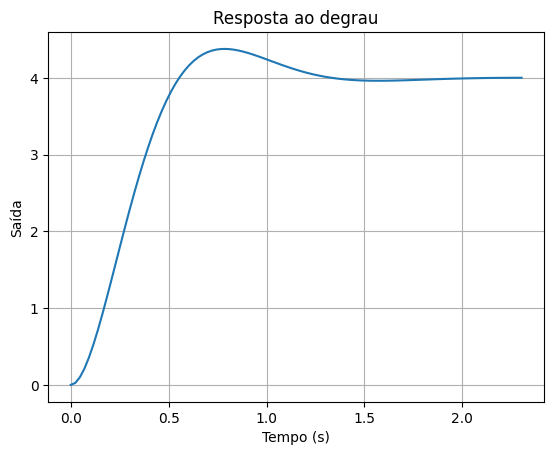

In [12]:
plt.plot(t, y)
plt.title("Resposta ao degrau")
plt.xlabel("Tempo (s)")
plt.ylabel("Saída")
plt.grid(True)
plt.show()

Agora, vendo como é a cara da resposta ao degrau, podemos calcular os parâmetros. A biblioteca control tem outra função que calcula vários desses parâmetros que vamos utilizar. Passando a função de transferência de malha fechada para a função step_info, a mesma nos retornará um dicionário do python (uma estrutura de dados que tem chave e valor) da seguinte forma:

In [16]:
info = ctrl.step_info(FTMF)

for key, value in info.items():
  print(f"{key}: {value}")

RiseTime: 0.3721349645242902
SettlingTime: 1.2094386347039432
SettlingMin: 3.7023980182833394
SettlingMax: 4.3789847701545765
Overshoot: 9.474619253864415
Undershoot: 0
Peak: 4.3789847701545765
PeakTime: 0.7907867996141167
SteadyStateValue: 4.0


Podemos ver que vários dos parâmetros já foram calculados automaticamente, como o tempo de acomodação (SettlingTime). O problema é que ainda teremos que calcular o tempo de atraso da seguinte forma:

Pegamos o valor de saída estacionário e encontramos qual é o valor de 50% do estacionário

In [17]:
# Tempo de atraso: tempo que a saída demora para chegar em 50% do valor estacionário

valor_estacionario = info["SteadyStateValue"]
metade_estacionario = 0.5 * valor_estacionario
print(metade_estacionario)

2.0


Tendo esse valor, podemos ver na nossa saída qual é o valor de tempo correspondente a esse valor de saída. O problema é que estamos utilizando intervalos discretos e não contínuos, visto que estamos utilizando arrays para representar a curva da função. Por isso, podemos antes fazer uma interpolação de valores, de forma que vamos encontrar o tempo exato correspondente a aquele valor de saída. Para isso, podemos usar a função interp da biblioteca numpy. A biblioteca recebe 3 parâmetros: o valor procurado, o array que representa a grandeza que temos o valor e o array que representa a grandeza que queremos encontrar o valor correspondente. Como tempos o valor de saída e queremos encontrar o tempo, faremos da seguinte forma:

In [20]:
tempo_atraso = np.interp(metade_estacionario, y, t)

print(tempo_atraso)

0.27165473695207115


Assim teremos o tempo de atraso. Já para o tempo de subida, a função step_info nos retorna um "RiseTime", porém não é só daquela forma que podemos representar esse tempo de subida no gráfico, podemos também desenhar um intervalo de tempo que será definido dessa forma:

In [28]:
# Tempo de subida: tempo que a saída demora para sair de 10% até 90% do valor estacionário

tempo_subida = [np.interp(0.1 * valor_estacionario, y, t), np.interp(0.9 * valor_estacionario, y, t)]

print(f"O tempo de subida vai de {tempo_subida[0]}s até {tempo_subida[1]}s.")

O tempo de subida vai de 0.09895539908497167s até 0.4702886650270442s.


Tendo todos esses valores, podemos plotar o gráfico com todos os parâmetros que encontramos. Estamos novamente fazendo uma interpolação para o tempo de acomodação, pois a função step_info só nos dá o valor de t e não o de y.

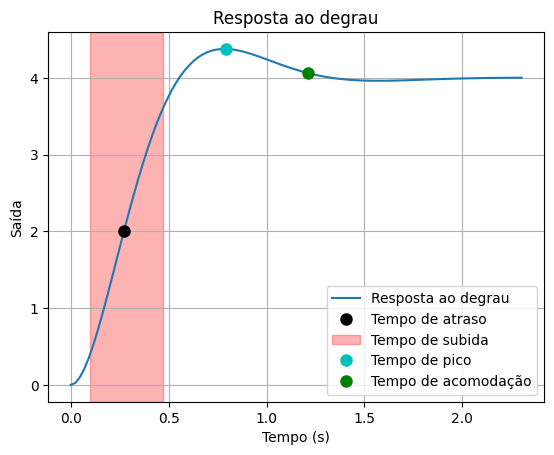

In [44]:
plt.plot(t, y, label="Resposta ao degrau")
plt.plot(tempo_atraso, metade_estacionario, "ko", markersize=8, label="Tempo de atraso") # Desenha um ponto
plt.axvspan(tempo_subida[0], tempo_subida[1], color="red", alpha=0.3, label="Tempo de subida") # Desenha um intervalo
plt.plot(info["PeakTime"], info["Peak"], "co", markersize=8, label="Tempo de pico") # Desenha um ponto
plt.plot(info["SettlingTime"], np.interp(info["SettlingTime"], t, y), "go", markersize=8, label="Tempo de acomodação") # Desenha um ponto
plt.legend()
plt.grid()
plt.title("Resposta ao degrau")
plt.xlabel("Tempo (s)")
plt.ylabel("Saída")
plt.show()

Por fim, para o máximo sobressinal, devemos calcular separado pois o mesmo não representa um ponto no gráfico e sim um intervalo vertical (intervalo de saídas).

In [45]:
MSS = (info["Peak"] - info["SteadyStateValue"]) / info["SteadyStateValue"]

print(f'MÁXIMO SOBRESSINAL = {(MSS * 100):.2f}%')

MÁXIMO SOBRESSINAL = 9.47%


Dessa maneira, podemos caracterizar diversos tipos de sistemas de controle usando seus parâmetros de resposta transitória.

## Exercício

Dado o sistema realimentado $\frac{Y(s)}{R(s)} = \frac{16}{s^2 + 2.4s + 16}$, onde $Y(s)$ é a saída e $R(s)$ é a entrada calcule seus parâmetros de regime transitório usando o python.